# Demo of Predictive State Smoothing (PRESS)

PRESS is a kernel smoothing technique for any type of predictive learning problem (classification, regression, ...).

This notebook shows examples of how to use the main functionality for a regression and classification problem.  Core PRESS functionality and layers, though, can be used for any learning problem with non-standard activation functions.

See also


* Goerg (2018) *[Classification using Predictive State Smoothing (PRESS): A scalable kernel classifier for high-dimensional features with variable selection](https://research.google/pubs/pub46767/)*.

* Goerg (2017) *[Predictive State Smoothing (PRESS): Scalable non-parametric regression for high-dimensional data with variable selection](https://research.google/pubs/pub46141/).*


In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import logging
import datetime
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [3]:
from pypress.keras import layers
from pypress.keras import initializers
from pypress.keras import regularizers
from pypress import utils

importlib.reload(layers)

<module 'pypress.keras.layers' from '/home/georg/Projects/pypress/pypress/keras/layers.py'>

# Utility functions and setup

In [26]:
# misc helper functions
from typing import Tuple, Any
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler


def _get_loss_activation_metrics(y: pd.Series) -> Tuple[Any, Any, Any]:

    if len(np.unique(y)) == 2:
        act = "sigmoid"
        loss_fn = "binary_crossentropy"
        metrics = [tf.keras.metrics.AUC(curve="PR", name="aupr"), tf.keras.metrics.AUC(curve="ROC", name="auc_roc")]
    elif len(np.unique(y)) <  11:#isinstance(y.iloc[0], str):
        act = "softmax"
        loss_fn = "sparse_categorical_crossentropy"
        metrics = [tf.keras.metrics.CategoricalAccuracy()]
    else:
        act = "linear"
        loss_fn = "mse"
        metrics = [tf.keras.metrics.mean_squared_error]
        
        if (y >= 0.).all():
            act = "softplus"
            loss_fn = "mse"

    return (loss_fn, act, metrics)


def _get_recommended_callbacks():
    logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    return [tf.keras.callbacks.EarlyStopping(patience=10),
                             tensorboard_callback], logdir


def _scale_df(X, scaler = None):
    
    if scaler is None:
        scaler = RobustScaler()
        scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), scaler


def _train_test_scale(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    X_train_s, scaler = _scale_df(X_train, None)
    X_test_s, scaler = _scale_df(X_test, scaler)
    
    return (X_train, y_train, X_test, y_test), scaler


# Classification

In [121]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

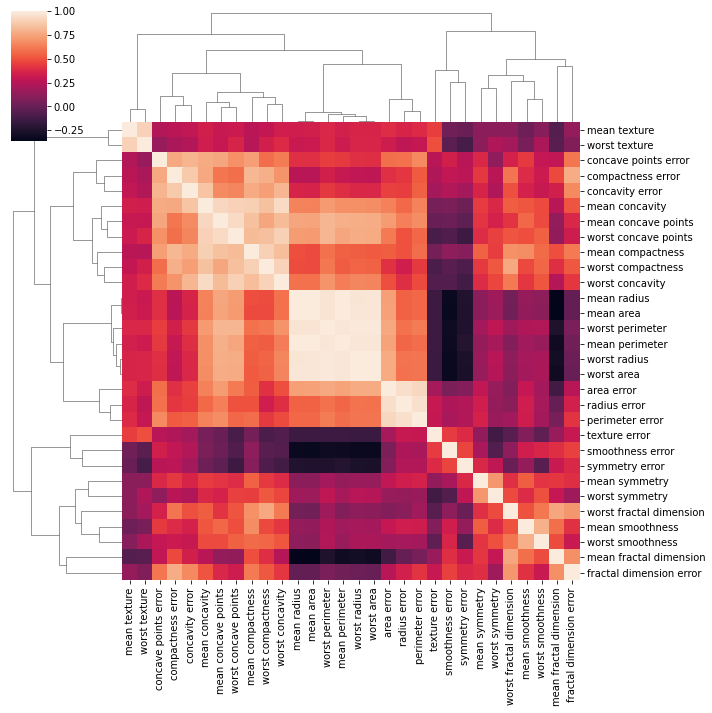

In [122]:
sns.clustermap(X.corr("spearman"))

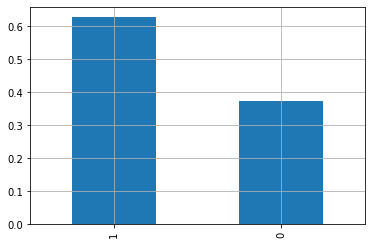

In [123]:
y.value_counts(normalize=True).plot.bar()
plt.grid()

In [124]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape, X_ts.shape

((455, 30), (114, 30))

In [125]:
loss_fn, act, metrics = _get_loss_activation_metrics(y)

feat_input = tf.keras.layers.Input(shape=(X.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "selu"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(10.))(hidden)
pred = layers.PredictiveStateMeans(units=1, activation=act)(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 sequential_27 (Sequential)  (None, 30)                3400      
                                                                 
 predictive_state_simplex_4   (None, 5)                155       
 (PredictiveStateSimplex)                                        
                                                                 
 predictive_state_means_4 (P  (None, 1)                5         
 redictiveStateMeans)                                            
                                                                 
Total params: 3,560
Trainable params: 3,400
Non-trainable params: 160
_________________________________________________________________


In [126]:
clbks, logdir_str = _get_recommended_callbacks()

logs/20211128-174951


In [127]:
history = mod.fit(X_tr, y_tr, epochs=30, 
                  validation_data=(X_ts, y_ts),
                  callbacks=clbks,
                 )

Epoch 1/30
15/15 [==============================] - 2s 29ms/step - loss: 0.6537 - aupr: 0.9042 - auc_roc: 0.8518 - val_loss: 0.6779 - val_aupr: 0.9368 - val_auc_roc: 0.8820
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6403 - aupr: 0.9542 - auc_roc: 0.9277 - val_loss: 0.6727 - val_aupr: 0.9818 - val_auc_roc: 0.9765
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6331 - aupr: 0.9688 - auc_roc: 0.9503 - val_loss: 0.6598 - val_aupr: 0.9822 - val_auc_roc: 0.9781
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6296 - aupr: 0.9701 - auc_roc: 0.9525 - val_loss: 0.6524 - val_aupr: 0.9841 - val_auc_roc: 0.9800
Epoch 5/30
15/15 [==============================] - 0s 8ms/step - loss: 0.6260 - aupr: 0.9770 - auc_roc: 0.9615 - val_loss: 0.6443 - val_aupr: 0.9844 - val_auc_roc: 0.9803
Epoch 6/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6268 - aupr: 0.9607 - auc_roc: 0.9398 - val_loss: 0.6376 - val_au

In [128]:
%tensorboard --logdir $logdir_str

In [130]:
preds = pd.DataFrame({"true": y_ts, "pred": mod.predict(X_ts).ravel()})

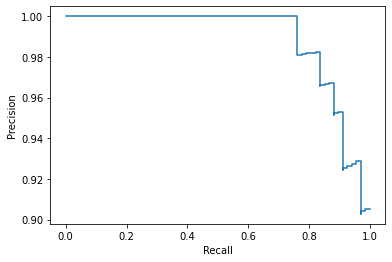

In [131]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(preds["true"], preds["pred"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


(114, 30)


<AxesSubplot:>

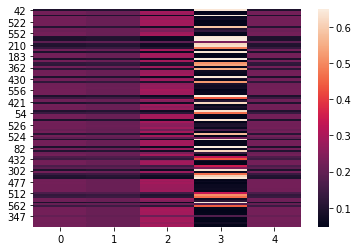

In [132]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = pd.DataFrame(state_mapping(X_ts.values).numpy(), index=X_ts.index)
sns.heatmap(pred_emb)

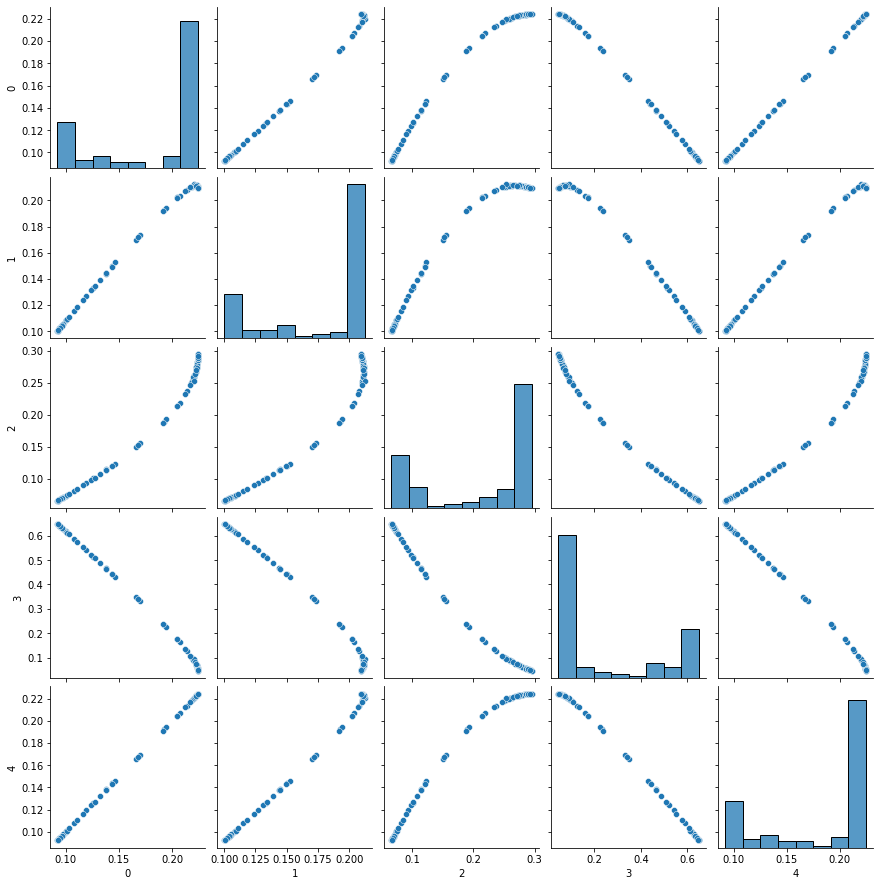

In [133]:
sns.pairplot(pred_emb)

In [134]:
X_state = utils.agg_data_by_state(X_ts, pred_emb)
X_state

,0,1,2,3,4
mean radius,13.258019,13.382694,12.827821,16.871966,13.254333
mean texture,19.255013,19.320079,19.033632,21.137505,19.253097
mean perimeter,86.157905,87.029124,83.150816,111.357683,86.132149
mean area,569.043218,580.560003,529.669331,913.295076,568.703312
mean smoothness,0.096916,0.097106,0.096261,0.102122,0.096910
mean compactness,0.102438,0.103870,0.097470,0.142705,0.102396
mean concavity,0.080251,0.082671,0.071893,0.148668,0.080179
mean concave points,0.041939,0.043309,0.037233,0.081602,0.041898
mean symmetry,0.183070,0.183478,0.181719,0.196133,0.183058
mean fractal dimension,0.064115,0.064086,0.064220,0.063430,0.064116


In [135]:
mod.layers[-1].state_conditional_means.numpy()

array([[0.69365704],
       [0.67717934],
       [0.76145256],
       [0.31623834],
       [0.6941621 ]], dtype=float32)

In [136]:
utils.state_size(pred_emb, normalize=True)

state
0    0.185211
1    0.179941
2    0.212778
3    0.236689
4    0.185381
dtype: float32

In [137]:
X_state

state,0,1,2,3,4
mean radius,13.258019,13.382694,12.827821,16.871966,13.254333
mean texture,19.255013,19.320079,19.033632,21.137505,19.253097
mean perimeter,86.157905,87.029124,83.150816,111.357683,86.132149
mean area,569.043218,580.560003,529.669331,913.295076,568.703312
mean smoothness,0.096916,0.097106,0.096261,0.102122,0.096910
mean compactness,0.102438,0.103870,0.097470,0.142705,0.102396
mean concavity,0.080251,0.082671,0.071893,0.148668,0.080179
mean concave points,0.041939,0.043309,0.037233,0.081602,0.041898
mean symmetry,0.183070,0.183478,0.181719,0.196133,0.183058
mean fractal dimension,0.064115,0.064086,0.064220,0.063430,0.064116


<AxesSubplot:>

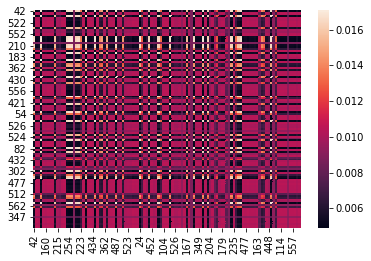

In [138]:
sns.heatmap(pred_emb.dot(utils.col_normalize(pred_emb).transpose()))

## Explain predictions

In [139]:
pred_fn = lambda x: mod.predict(x)[:, 0]

In [140]:
import shap
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(pred_fn, X_ts)
explainer.feature_names

In [141]:
shap_values = explainer(X_ts.iloc[:20])  # ~20sec

Permutation explainer: 21it [00:27,  1.33s/it]                        


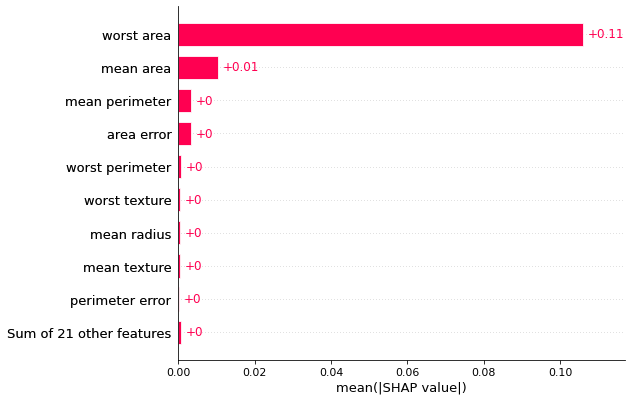

In [142]:
shap.plots.bar(shap_values)

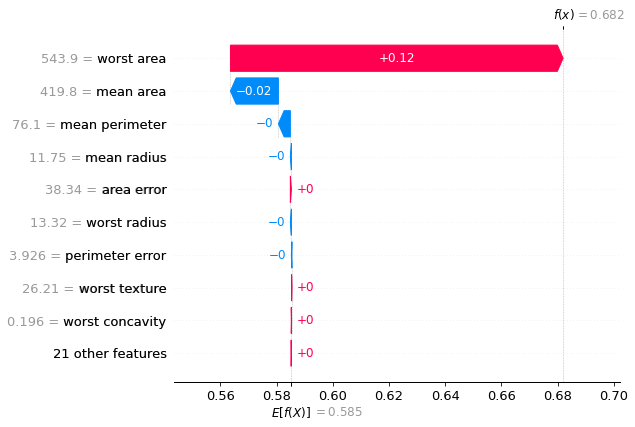

In [143]:
shap.plots.waterfall(shap_values[5])

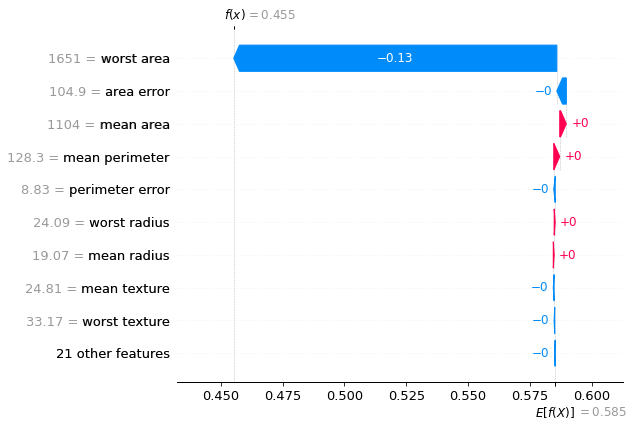

In [144]:
shap.plots.waterfall(shap_values[0])

# Regression


In [95]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)

In [96]:
X, y = housing["data"], housing["target"]
X.shape, y.shape

((20640, 8), (20640,))

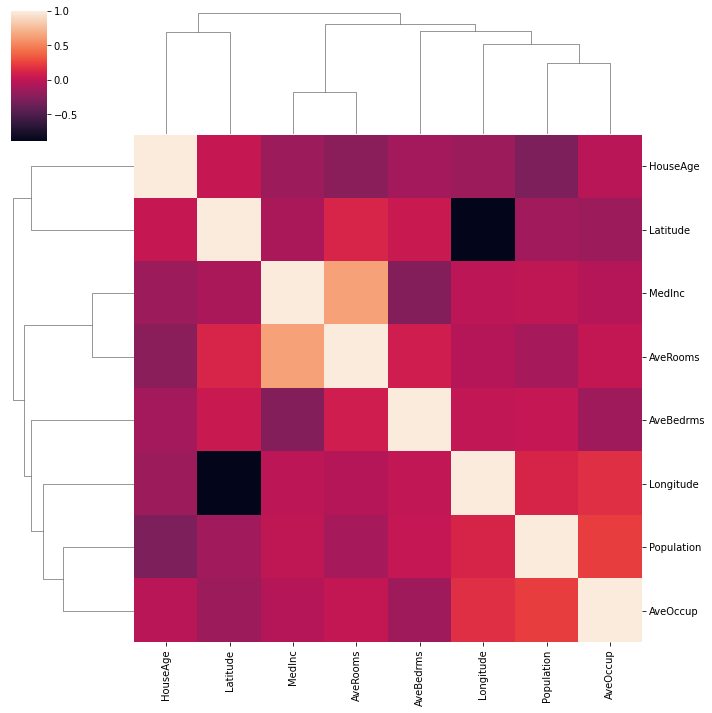

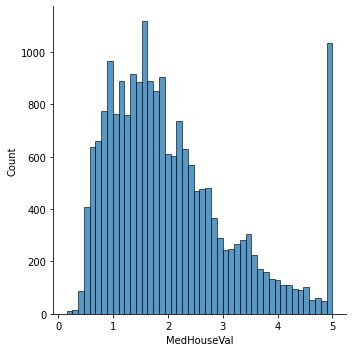

In [97]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [98]:
X = X.loc[y < 5]
y = y.loc[y < 5]

X.shape, y.shape

((19648, 8), (19648,))

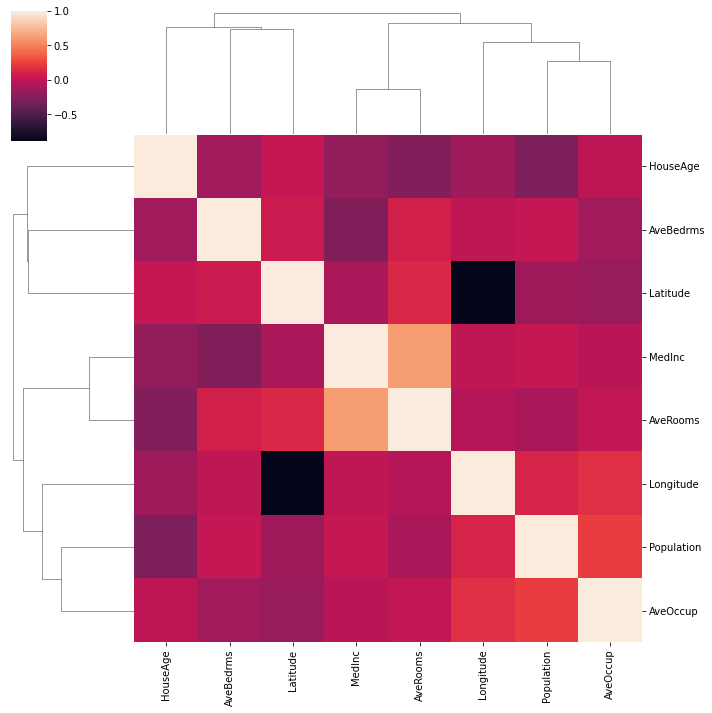

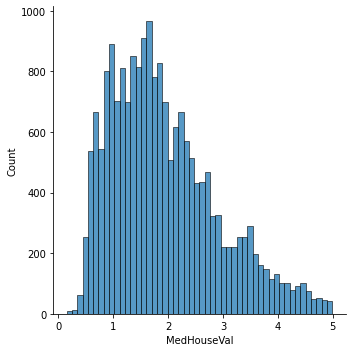

In [99]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [100]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape

(15718, 8)

In [102]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_ts)
print(act, loss_fn)

feat_input = tf.keras.layers.Input(shape=(X_tr.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(30, "relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
eps_mapping = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(l1=0.1),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001))
pred_states = eps_mapping(hidden)
state_mean_layer = layers.PredictiveStateMeans(units=1, activation=act)
pred = state_mean_layer(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
            metrics=metrics)
mod.summary()

softplus mse
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 sequential_25 (Sequential)  (None, 30)                1440      
                                                                 
 predictive_state_simplex_2   (None, 5)                155       
 (PredictiveStateSimplex)                                        
                                                                 
 predictive_state_means_2 (P  (None, 1)                5         
 redictiveStateMeans)                                            
                                                                 
Total params: 1,600
Trainable params: 1,480
Non-trainable params: 120
_________________________________________________________________


In [103]:
eps_mapping.trainable_weights

[<tf.Variable 'predictive_state_simplex_2/kernel:0' shape=(30, 5) dtype=float32, numpy=
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float

In [104]:
state_mean_layer.trainable_variables

[<tf.Variable 'predictive_state_means_2/state_conditional_mean_logits:0' shape=(5, 1) dtype=float32, numpy=
 array([[-0.5809157 ],
        [ 0.91503096],
        [ 0.6469176 ],
        [-0.27038574],
        [ 0.53077364]], dtype=float32)>]

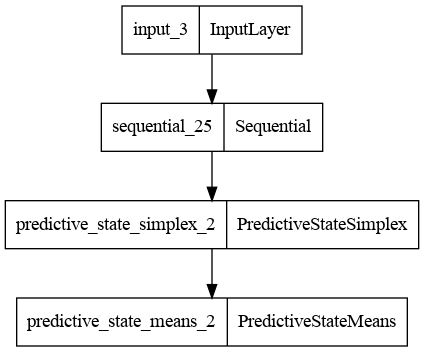

In [105]:
tf.keras.utils.plot_model(mod)

In [106]:
history = mod.fit(X_tr, y_tr, epochs=10, batch_size=32,
                  validation_data=(X_ts, y_ts),
                  callbacks=[],#_get_recommended_callbacks()
                 )

Epoch 1/10
492/492 [==============================] - 2s 2ms/step - loss: 1.0792 - mean_squared_error: 1.0607 - val_loss: 0.9516 - val_mean_squared_error: 0.9386
Epoch 2/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9548 - mean_squared_error: 0.9440 - val_loss: 0.9534 - val_mean_squared_error: 0.9449
Epoch 3/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9523 - mean_squared_error: 0.9442 - val_loss: 0.9468 - val_mean_squared_error: 0.9393
Epoch 4/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9512 - mean_squared_error: 0.9443 - val_loss: 0.9443 - val_mean_squared_error: 0.9381
Epoch 5/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9505 - mean_squared_error: 0.9442 - val_loss: 0.9441 - val_mean_squared_error: 0.9391
Epoch 6/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9492 - mean_squared_error: 0.9445 - val_loss: 0.9428 - val_mean_squared_error: 0.9388
Epoch 7/10
492/492 [========

In [107]:
mod.layers[-1].state_conditional_means.numpy().ravel()

array([0.7210909 , 1.9593034 , 1.9563857 , 0.90039456, 1.7017708 ],
      dtype=float32)

<AxesSubplot:>

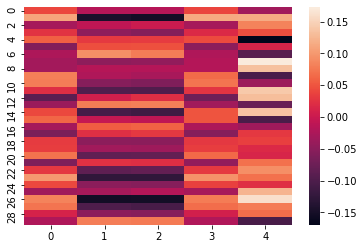

In [108]:
sns.heatmap(eps_mapping.trainable_weights[0].numpy())

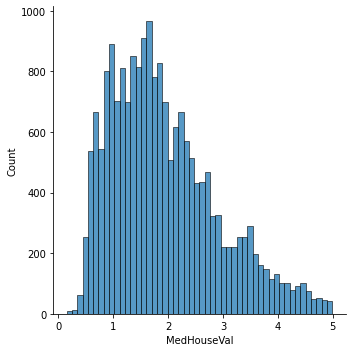

In [109]:
sns.displot(y)

/home/georg/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


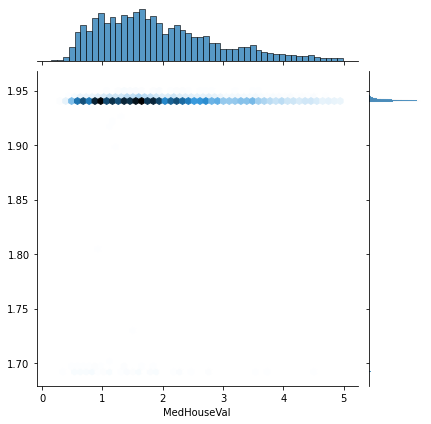

In [110]:
y_pred = mod.predict(X)

sns.jointplot(y, y_pred.ravel(), kind="hex")

(3930, 8)


<AxesSubplot:>

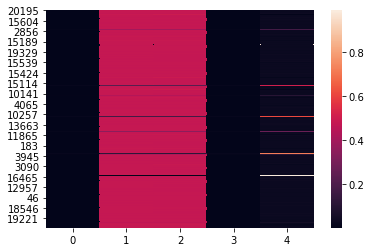

In [111]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = state_mapping(X_ts.values).numpy()
pred_emb = pd.DataFrame(pred_emb, index=X_ts.index)
sns.heatmap(pred_emb)

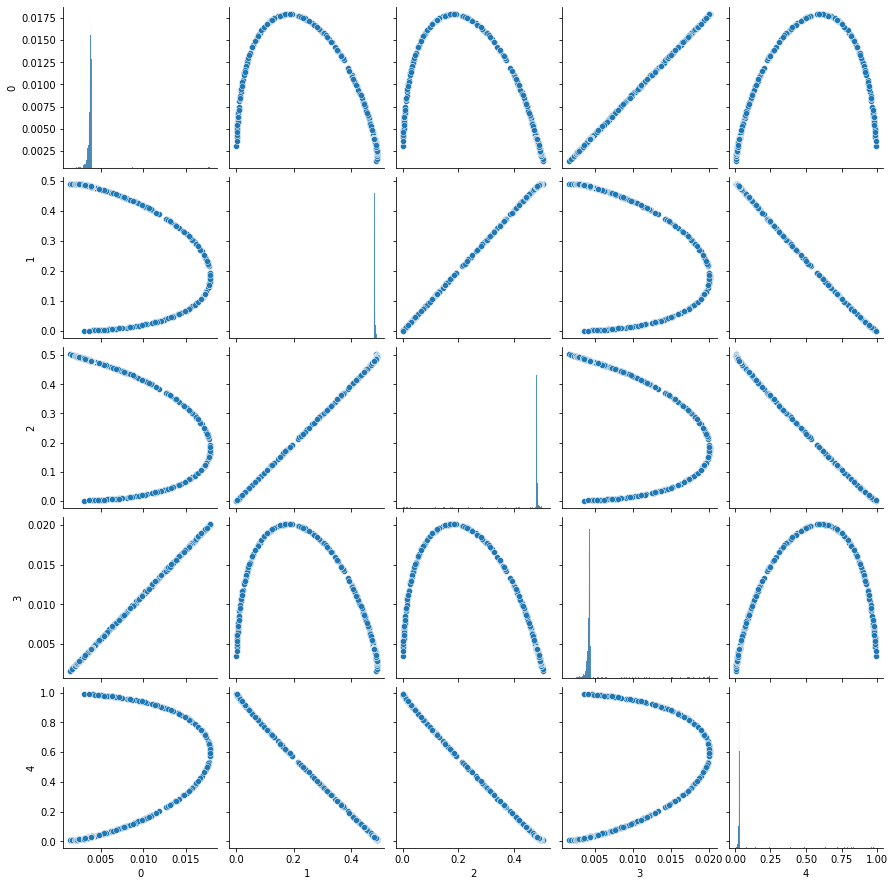

In [112]:
sns.pairplot(pred_emb)

In [113]:
pred_emb.shape

(3930, 5)

In [114]:
utils.col_normalize(pred_emb).sum(axis=0)

state
0    0.999998
1    0.999999
2    1.000000
3    0.999998
4    1.000000
dtype: float32

In [115]:
X_ts.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20195,3.4450,8.0,4.784124,1.135528,3012.0,2.915779,34.27,-119.20
19704,3.3793,18.0,6.322835,1.066929,1817.0,3.576772,39.11,-121.64
6524,3.1875,30.0,4.171488,1.138430,2481.0,5.126033,34.06,-118.04
2997,2.5575,12.0,5.202677,1.049713,1294.0,2.474187,35.32,-119.03
14504,3.3500,14.0,4.434343,1.018939,1835.0,2.316919,32.87,-117.22


In [116]:
utils.state_size(pred_emb)

state
0      16.374559
1    1835.303345
2    1833.772339
3      18.390760
4     226.160645
dtype: float32

In [117]:
utils.agg_data_by_state(pred_emb, X_ts).round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
state,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.47,0.47,0.46,0.46,0.48,0.47,0.47,0.47
2,0.47,0.47,0.46,0.46,0.48,0.47,0.47,0.47
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.06,0.06,0.07,0.07,0.03,0.06,0.06,0.06


# Multi-class classification (MNIST)

Example of multi-class classification using MNIST.

In [145]:
digits = sklearn.datasets.load_digits()
n_samples = len(digits.images)
data = digits.images#.reshape((n_samples, -1))

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, digits.target, test_size=0.2, shuffle=False
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 8, 8), (360, 8, 8), (1437,), (360,))

In [146]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [147]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_train)
loss_fn, act

('sparse_categorical_crossentropy', 'softmax')

In [148]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, (4, 4), strides = (2, 2), name = 'conv0', input_shape = (8, 8, 1)))

model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D((3, 3), name='max_pool'))
model.add(tf.keras.layers.Conv2D(16, (1, 1), strides = (1,1), name="conv1"))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.AveragePooling2D((1, 1), name='avg_pool'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(50, activation="relu", name='rl'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.PRESS(units=10, n_states=5, activation=act))
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 3, 3, 64)          1088      
                                                                 
 bn0 (BatchNormalization)    (None, 3, 3, 64)          256       
                                                                 
 activation_42 (Activation)  (None, 3, 3, 64)          0         
                                                                 
 max_pool (MaxPooling2D)     (None, 1, 1, 64)          0         
                                                                 
 conv1 (Conv2D)              (None, 1, 1, 16)          1040      
                                                                 
 activation_43 (Activation)  (None, 1, 1, 16)          0         
                                                                 
 avg_pool (AveragePooling2D)  (None, 1, 1, 16)       

In [149]:
model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.02),
             metrics=metrics)

In [150]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
45/45 [==============================] - 1s 5ms/step - loss: 2.1641 - categorical_accuracy: 0.0000e+00 - val_loss: 2.0787 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
45/45 [==============================] - 0s 3ms/step - loss: 1.8957 - categorical_accuracy: 0.0000e+00 - val_loss: 1.8761 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
45/45 [==============================] - 0s 3ms/step - loss: 1.8039 - categorical_accuracy: 0.3305 - val_loss: 2.2443 - val_categorical_accuracy: 0.7667
Epoch 4/10
45/45 [==============================] - 0s 3ms/step - loss: 1.6665 - categorical_accuracy: 0.0508 - val_loss: 1.8098 - val_categorical_accuracy: 0.4722
Epoch 5/10
45/45 [==============================] - 0s 3ms/step - loss: 1.5881 - categorical_accuracy: 0.3062 - val_loss: 1.7382 - val_categorical_accuracy: 0.4861
Epoch 6/10
45/45 [==============================] - 0s 3ms/step - loss: 1.6138 - categorical_accuracy: 0.3542 - val_loss: 2.2668 - val_categorical_accuracy: 0.1472


<AxesSubplot:>

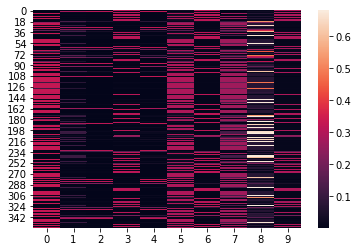

In [151]:
sns.heatmap(pd.DataFrame(model.predict(X_test)))

# Example of single `PRESS()` layer

In [152]:
mod = tf.keras.Sequential()
mod.add(layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictive_state_simplex_5   (None, 6)                186       
 (PredictiveStateSimplex)                                        
                                                                 
 predictive_state_means_5 (P  (None, 1)                6         
 redictiveStateMeans)                                            
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mod.fit(X_tr, y_tr, epochs=2)

In [154]:
mod = tf.keras.Sequential()
mod.add(layers.PRESS(units=1, n_states=6, activation="sigmoid", activity_regularizer=regularizers.DegreesOfFreedom(l1=0.1, df=2.), input_dim=X.shape[1]))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 press_4 (PRESS)             (None, 1)                 192       
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mod.fit(X_tr, y_tr, epochs=12)

In [10]:
from sklearn.datasets import load_breast_cancer
import sklearn
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_s = sklearn.preprocessing.robust_scale(X)  # See demo.ipynb to properly scale X with train/test split


import tensorflow as tf
from pypress.keras import layers
from pypress.keras import regularizers

mod = tf.keras.Sequential()
# see layers.PRESS() for single layer wrapper
mod.add(layers.PredictiveStateSimplex(
            n_states=6,
            activity_regularizer=regularizers.Uniform(0.01),
            input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=[tf.keras.metrics.AUC(curve="PR", name="auc_pr")])
mod.summary()
mod.fit(X_s, y, epochs=10, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictive_state_simplex_6   (None, 6)                186       
 (PredictiveStateSimplex)                                        
                                                                 
 predictive_state_means_6 (P  (None, 1)                6         
 redictiveStateMeans)                                            
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
15/15 [==============================] - 1s 17ms/step - loss: 0.5911 - auc_pr: 0.9795 - val_loss: 0.4856 - val_auc_pr: 0.9975
Epoch 2/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4933 - auc_pr: 0.9935 - val_loss: 0.4265 - val_auc_pr: 0.9995
Epoch 3/10
15/15 [=============================